# Cat vs. Dog vs. Fox: Transfer Learning in PyTorch

## Objective
Apply transfer learning techniques to fine-tune a pre-trained model in PyTorch for a multi-class classification task: distinguishing between images of cats, dogs, and foxes. This project develops skills in dataset preparation, model fine-tuning, and performance evaluation.
## Problem Description
Cats, dogs, and foxes are often confused due to their physical similarities, such as fur patterns, ear shapes, and size. This project aims to create a machine learning model that classifies images into one of three categories:

* Cat
* Dog
* Fox

Using transfer learning, this project leverages the pre-trained ResNet model from PyTorch to develop an effective classification system.

## Requirements

### Data Preparation:
1. Use or create a dataset with labeled images of cats, dogs, and foxes. Suggested sources include public image datasets such as those on Kaggle.
2. Split the dataset into training, validation, and test sets.
3. Preprocess the images to meet the input requirements of your chosen pre-trained model (e.g., resizing, normalization).

For my dataset I found an animal classification dataset from Kaggle at: https://www.kaggle.com/datasets/anthonytherrien/image-classification-64-classes-animal.

In [132]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anthonytherrien/image-classification-64-classes-animal")

print("Path to dataset files:", path)

Path to dataset files: /Users/michael.murray.iv/.cache/kagglehub/datasets/anthonytherrien/image-classification-64-classes-animal/versions/1


In [133]:
import os
from PIL import Image
from torchvision import transforms

# Define paths
cat_dir = os.path.join(path, "image/cat")
dog_dir = os.path.join(path, "image/dog")
fox_dir = os.path.join(path, "image/fox")

# Get the list of images in each category
cats = os.listdir(cat_dir)
dogs = os.listdir(dog_dir)
foxes = os.listdir(fox_dir)

# Create lists for image paths and labels
image_paths = []
labels = []

# Loop through each directory and assign labels
for img_name in cats:
    image_paths.append(os.path.join(cat_dir, img_name))
    labels.append(0)  # 0 for cat

for img_name in dogs:
    image_paths.append(os.path.join(dog_dir, img_name))
    labels.append(1)  # 1 for dog

for img_name in foxes:
    image_paths.append(os.path.join(fox_dir, img_name))
    labels.append(2)  # 2 for fox


In [134]:

# Now, you can proceed to transform the images and create the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),  # Convert to tensor
])

# Load images as tensors

image_tensors = []
for img_path in image_paths:
    img = Image.open(img_path).convert("RGB")  # Open and ensure RGB format
    img_tensor = transform(img)  # Apply the transformations
    image_tensors.append(img_tensor)

# Convert lists to PyTorch tensors
image_tensors = torch.stack(image_tensors)  # Shape: [N, 3, 224, 224]
labels_tensor = torch.tensor(labels)        # Shape: [N]


In [135]:
from torch.utils.data import TensorDataset, DataLoader, random_split

# Create a TensorDataset
dataset = TensorDataset(image_tensors, labels_tensor)

# Split into train, validation, and test sets
train_size = int(0.7 * len(dataset))  # 70% training
val_size = int(0.15 * len(dataset))   # 15% validation
test_size = len(dataset) - train_size - val_size  # Remaining 15% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Iterate through training DataLoader to see the batches
for batch_features, batch_targets in train_loader:
    print("Train Batch Features Shape:", batch_features.shape)
    print("Train Batch Targets Shape:", batch_targets.shape)

    break

Train Batch Features Shape: torch.Size([32, 3, 224, 224])
Train Batch Targets Shape: torch.Size([32])


### Model Selection and Fine-Tuning:
1. Choose a pre-trained model from PyTorch’s torchvision.models library (e.g., ResNet, VGG, or EfficientNet).
2. Replace the model’s classification head with a custom fully connected layer for three output classes (cat, dog, fox).
3. Fine-tune the model on your dataset, optimizing the training process to achieve the best results.

In [138]:
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import ssl
from torchvision.models import ResNet18_Weights


ssl._create_default_https_context = ssl._create_unverified_context

resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)

for param in resnet.parameters():
    param.requires_grad = True

num_classes = 3  # new classification head for three output classes
resnet.fc = nn.Linear(resnet.fc.in_features, num_classes)




In [139]:
import torch.optim as optim

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer (only the parameters of the new head)
# optimizer = optim.Adam(resnet.fc.parameters(), lr=0.001)

# If you unfreeze other layers, use:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.001)


In [140]:
# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet.to(device)

# Training loop
num_epochs = 10  # Set your number of epochs
for epoch in range(num_epochs):
    resnet.train()  # Set model to training mode
    running_loss = 0.0

    for images, labels in train_loader:
        # Move data to device
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")


Epoch 1/10, Loss: 0.19619856257922946


KeyboardInterrupt: 

In [126]:
# Validation loop
resnet.eval()  # Set model to evaluation mode
val_loss = 0.0
correct = 0
total = 0

with torch.no_grad():  # Disable gradient computation
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = resnet(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Compute accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / total:.2f}%")


Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Validation Loss: 0.002045381348580122, Accuracy: 100.00%


In [127]:
from sklearn.metrics import precision_score, recall_score, f1_score
import torch

# Testing
resnet.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = resnet(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Collecting all true labels and predictions
        all_labels.extend(labels.cpu().numpy())  # Convert tensor to numpy array for metrics
        all_preds.extend(predicted.cpu().numpy())

# Calculate precision, recall, and F1 score for each class
precision = precision_score(all_labels, all_preds, average=None)  # Precision for each class
recall = recall_score(all_labels, all_preds, average=None)  # Recall for each class
f1 = f1_score(all_labels, all_preds, average=None)  # F1 score for each class

print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1 Score per class: {f1}")

# Print the test accuracy
test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")


Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Precision per class: [1. 1. 1.]
Recall per class: [1. 1. 1.]
F1 Score per class: [1. 1. 1.]
Test Accuracy: 100.00%


Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured


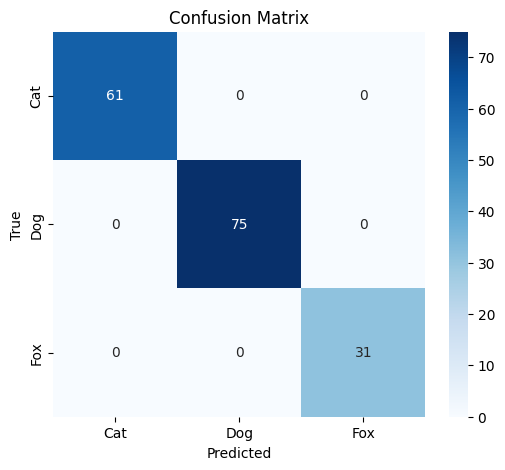

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

# Testing
resnet.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)

        # Collecting all true labels and predictions
        all_labels.extend(labels.cpu().numpy())  # Convert tensor to numpy array for metrics
        all_preds.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Visualize the confusion matrix using seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog', 'Fox'], yticklabels=['Cat', 'Dog', 'Fox'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [129]:
import matplotlib.pyplot as plt
import torch
from PIL import Image
import torchvision.transforms as transforms

# Define transformation to ensure correct image format
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Testing
resnet.eval()
misclassified_images = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = resnet(images)
        _, predicted = torch.max(outputs, 1)

        # Identify misclassified images
        for i in range(len(labels)):
            if predicted[i] != labels[i]:  # Misclassification
                # Store misclassified images along with actual and predicted labels
                misclassified_images.append((images[i].cpu(), labels[i].item(), predicted[i].item()))

# Function to plot misclassified images
def plot_misclassified_images(misclassified_images):
    # Check if there are any misclassified images
    if misclassified_images:
        # If there is more than one misclassified image, create subplots
        if len(misclassified_images) > 1:
            fig, axes = plt.subplots(1, len(misclassified_images), figsize=(15, 5))
            for i, (image, true_label, pred_label) in enumerate(misclassified_images):
                # Convert tensor to PIL image
                img = transforms.ToPILImage()(image)

                # Display the image and print the actual and predicted labels
                axes[i].imshow(img)
                axes[i].axis('off')  # Hide axes
                axes[i].set_title(f"True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}")
        else:
            # If only one misclassified image, don't use subplots
            fig, ax = plt.subplots(figsize=(5, 5))
            image, true_label, pred_label = misclassified_images[0]

            img = transforms.ToPILImage()(image)
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"True: {class_labels[true_label]}\nPred: {class_labels[pred_label]}")

        plt.show()
    else:
        print("No misclassified images.")

# If there are any misclassified images, display them
plot_misclassified_images(misclassified_images)


Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
Activations captured
No misclassified images.


In [54]:
torch.save(resnet.state_dict(), "trained_resnet_model.pth")
resnet.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Testing specific images for fun and experimentation

In [56]:
from torchvision import models
import torch.nn as nn

# Define the model architecture
def recreate_model():
    # Load a pre-trained ResNet18 model
    model = models.resnet18(pretrained=False)  # Use pretrained=False since you'll load your own weights

    # Modify the classification head
    num_classes = 3  # Replace with your actual number of classes
    model.fc = nn.Linear(model.fc.in_features, num_classes)  # Match the architecture used during training

    return model

# Create the model
model = recreate_model()

# Load the trained weights
model.load_state_dict(torch.load("trained_resnet_model.pth"))  # Replace with your saved state_dict path

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [87]:
from ipywidgets import FileUpload
from PIL import Image
from torchvision import transforms
import torch

# File upload widget
uploader = FileUpload(accept='.png', multiple=False)  # Accept PNG files
display(uploader)

# Define preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),          # Convert image to tensor
])



FileUpload(value=(), accept='.png', description='Upload')

In [145]:
import matplotlib.pyplot as plt 
# Function to handle uploaded file and make predictions
def predict_uploaded_image(model, uploader, class_labels):
    # Ensure an image has been uploaded
    if len(uploader.value) > 0:
        uploaded_file = uploader.value[0]  # Extract the first file
        
        
        img = Image.open(io.BytesIO(uploaded_file['content'])).convert("RGB")  # Convert to RGB

        # Display the uploaded image
        plt.imshow(img)  # Use matplotlib to display the image
        plt.axis('off')  # Hide axis
        plt.show()  # Show the image
        
        # Preprocess the image
        img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

        # Move tensor to the device
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        img_tensor = img_tensor.to(device)
        # Perform prediction
        model.eval()  # Ensure the model is in evaluation mode
        with torch.no_grad():
            outputs = model(img_tensor)
        _, predicted_class = torch.max(outputs, 1)  # Get the class index
        predicted_label = class_labels[predicted_class.item()]
        return predicted_label
    else:
        return "No file uploaded."


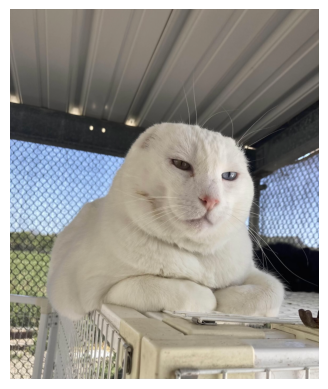

Predicted Class: Cat


In [146]:

# Define class labels
class_labels = {0: "Cat", 1: "Dog", 2: "Fox"}  # Replace with your labels

# Call the prediction function after uploading an image
predicted_label = predict_uploaded_image(model, uploader, class_labels)
print(f"Predicted Class: {predicted_label}")

### Evaluation:
1. Assess the model’s performance using metrics such as accuracy, precision, recall, and F1-score.
2. Visualize the confusion matrix to identify common misclassifications.

### Explainability (Optional):
Use tools like Grad-CAM to visualize what parts of the image the model focuses on for each class.
Discuss whether the model’s learned features align with human intuition (e.g., ear shape, snout length).

## Commit and Push changes to GitHub

In [107]:
commit_message = input("Enter your commit message: ")
!git add Transfer\ Learning.ipynb
!git commit -m "{commit_message}"
!git push origin main

Enter your commit message:  got model training and can correctly predict snowball. Still working on evaluation and overall notebook organization


[main f797052] got model training and can correctly predict snowball. Still working on evaluation and overall notebook organization
 1 file changed, 701 insertions(+), 102 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 189.81 KiB | 21.09 MiB/s, done.
Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
To https://github.com/michaelmurrayiv/Transfer-Learning.git
   66f2e00..f797052  main -> main
